In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import shutil
import random
import math
from scipy.stats import iqr
from scipy.stats import linregress
from scipy.stats import norm
from scipy.stats import laplace
from os import listdir
from os.path import isfile, join
from datetime import datetime
from matplotlib.ticker import FuncFormatter

In [9]:
# Declaração de constantes e variáveis globais
DIR_CSV = "../csv/"
DIR_IMG = "../img_selecionadas/"

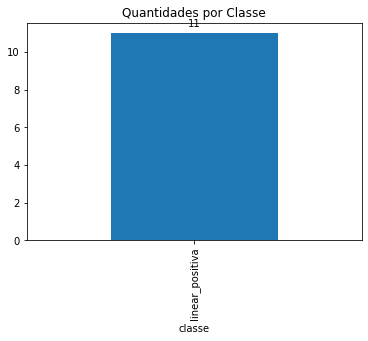

In [10]:
# Ler a lista de arquivos CSV
csv_files = [f for f in listdir(DIR_CSV) if (isfile(join(DIR_CSV, f)))]
data_modelos = pd.DataFrame(columns = ['acao', 'slope', 'intercept', 'r', 'p', 'std_err'])
                                             
for f in csv_files:                          
    # Montar o dataframe Pandas a partir do JSON
    pregao = pd.read_csv(join(DIR_CSV, f), low_memory = False)
    
    # Gerar o modelo de regressão linear (extração das features)
    data_inicio = "20190101"
    pregao_plot = pregao.query("dt_pregao >= {0}".format(data_inicio))
    aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': ['mean', iqr], 'vl_variacao': 'sum'})
    aux.columns = [' '.join(col).strip().replace(' ', '_') for col in aux.columns.values]
    slope, intercept, r, p, std_err = linregress(range(0, len(aux.index)), aux.vl_medio_mean)
    
    modelo = {}
    modelo["acao"] = f.replace(".csv", "")
    modelo["slope"] = slope
    modelo["intercept"] = intercept
    modelo["r"] = r
    modelo["r2"] = r * r
    modelo["p"] = p
    modelo["std_err"] = std_err
    
    # Extração de features para seleção das melhores ações
    meses_ganho = aux.query('vl_variacao_sum >= 0')['vl_variacao_sum'].count()
    meses_perda = aux.query('vl_variacao_sum < 0')['vl_variacao_sum'].count()
    ganho_medio = aux.query('vl_variacao_sum >= 0')['vl_variacao_sum'].mean()
    perda_media = aux.query('vl_variacao_sum < 0')['vl_variacao_sum'].mean()
    ganho_std = aux.query('vl_variacao_sum >= 0')['vl_variacao_sum'].std()
    perda_std = aux.query('vl_variacao_sum < 0')['vl_variacao_sum'].std()
    ultimo_vl_acao = aux.iloc[-1]['vl_medio_mean']
    iqr_min = aux['vl_medio_iqr'].min()
    iqr_max = aux['vl_medio_iqr'].max()
    iqr_atual = aux.iloc[-1]['vl_medio_iqr']
    ultimo_iiq_norm = (iqr_atual - iqr_min) / (iqr_max - iqr_min)    
    
    modelo["vl_variacao_media"] = aux['vl_variacao_sum'].mean()
    modelo["vl_variacao_std"] = aux['vl_variacao_sum'].std()
    modelo["meses_ganho"] = meses_ganho
    modelo["meses_perda"] = meses_perda
    modelo["ganho_medio"] = ganho_medio
    modelo["perda_media"] = perda_media
    modelo["ganho_std"] = ganho_std
    modelo["perda_std"] = perda_std    
    modelo["ultimo_vl_acao"] = ultimo_vl_acao
    modelo["ultimo_iiq_norm"] = ultimo_iiq_norm
    modelo["score"] = ganho_medio / ultimo_vl_acao
    modelo["risco"] = meses_perda / (meses_ganho + meses_perda)
    
    data_modelos = data_modelos.append(modelo, ignore_index = True)
    
condicoes = [(data_modelos['p'] < 1e-3) & (data_modelos['r2'] >= 0.3) & (data_modelos['slope'] < 0), (data_modelos['p'] < 1e-3) & (data_modelos['r2'] >= 0.3) & (data_modelos['slope'] >= 0), (data_modelos['p'] < 5e-2) & (data_modelos['std_err'] >= 0.2) & (data_modelos['slope'] < 0)]
classes = ['linear_negativa', 'linear_positiva', 'degrau']
data_modelos['classe'] = np.select(condicoes, classes, default = 'outro')
ax = data_modelos.groupby(['classe']).count().plot(kind = 'bar', y = 'acao', legend = False);
ax.set_title("Quantidades por Classe")
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='center',xytext=(0,10),textcoords='offset points')

In [11]:
classe = "linear_positiva"
ultimo_iiq_norm = 0.2
ultimo_vl_acao = 20
ganho_medio = 1
score = 0.1
risco = 0.6
acoes = ['KLBN11']
#selecionadas = data_modelos.query("classe == '{0}' & ultimo_iiq_norm < {1} & ultimo_vl_acao <= {2} & ganho_medio >= {3} & score >= {4} & risco < {5}".format(classe, ultimo_iiq_norm, ultimo_vl_acao, ganho_medio, score, risco))[["acao", "slope", "p", "std_err", "meses_ganho", "meses_perda", "ganho_medio", "ganho_std", "perda_media", "perda_std", "ultimo_vl_acao", "ultimo_iiq_norm", "score", "risco"]]
selecionadas = data_modelos.query("classe == '{0}' & ultimo_vl_acao <= {1}".format(classe, ultimo_vl_acao))[["acao", "slope", "p", "r2", "meses_ganho", "meses_perda", "ganho_medio", "ganho_std", "perda_media", "perda_std", "ultimo_vl_acao", "ultimo_iiq_norm", "score", "risco", "classe"]]
#selecionadas = data_modelos.query("acao == @acoes")[["acao", "slope", "p", "r2", "meses_ganho", "meses_perda", "ganho_medio", "ganho_std", "perda_media", "perda_std", "ultimo_vl_acao", "ultimo_iiq_norm", "score", "risco", "classe"]]
selecionadas

,acao,slope,p,r2,meses_ganho,meses_perda,ganho_medio,ganho_std,perda_media,perda_std,ultimo_vl_acao,ultimo_iiq_norm,score,risco,classe
0,RANI3,0.129060,7.520026e-15,0.774721,25.0,18.0,0.498400,0.432239,-0.468333,0.423643,6.798095,0.048583,0.073315,0.418605,linear_positiva
1,ETER3,0.460476,2.311163e-09,0.585393,22.0,21.0,2.260909,2.552840,-1.961905,1.998223,10.452381,0.052511,0.216306,0.488372,linear_positiva
2,PTBL3,0.179989,2.073463e-06,0.426405,23.0,20.0,1.007391,0.929136,-0.988500,1.062233,7.450476,0.267800,0.135212,0.465116,linear_positiva
3,POSI3,0.179765,7.100883e-07,0.454840,22.0,21.0,1.330000,1.204713,-1.173333,1.149375,6.070000,0.255230,0.219110,0.488372,linear_positiva
4,USIM5,0.199275,5.494143e-05,0.330698,23.0,20.0,1.179130,1.236284,-1.379000,0.969932,8.653810,0.056738,0.136256,0.465116,linear_positiva
5,ENAT3,0.156538,1.080194e-04,0.329378,27.0,13.0,1.107037,0.983506,-1.984615,1.691102,16.916667,0.255725,0.065441,0.325000,linear_positiva
6,TAEE3,0.119019,2.686812e-14,0.760386,24.0,19.0,0.566250,0.656948,-0.447368,0.355213,13.165238,0.246154,0.043011,0.441860,linear_positiva
7,MRFG3,0.383135,4.700893e-13,0.724789,23.0,20.0,1.491304,1.191051,-1.330000,1.145908,12.969524,0.173354,0.114985,0.465116,linear_positiva
8,FRAS3,0.259263,6.421772e-12,0.687728,26.0,17.0,0.800000,0.768791,-0.803529,0.878948,10.209524,0.910828,0.078358,0.395349,linear_positiva
9,JHSF3,0.084996,1.268548e-04,0.304068,25.0,18.0,0.716800,0.631973,-0.785556,0.753878,5.620476,0.051864,0.127534,0.418605,linear_positiva


In [13]:
pdfs = ["gauss", "laplace"]

def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

for acao in selecionadas['acao']:
    
    # =================================================
    # Inicialização das variáveis
    # =================================================
    scores = []
    
    # =================================================
    # Montar o dataframe Pandas a partir do JSON
    # =================================================
    pregao = pd.read_csv("{0}{1}.csv".format(DIR_CSV, acao), low_memory = False)

    data_inicio = "20190101"
    pregao_plot = pregao.query("dt_pregao >= {0}".format(data_inicio))
    
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (22.5, 20));
    fig.tight_layout(h_pad = 15.0);
    sns.set_style("whitegrid", {'grid.linestyle': '--'});

    # =====================================================
    # Boxplot da média mensal + gráfico de linha + volume
    # =====================================================
    ax1 = pregao_plot.boxplot(column = 'vl_medio', by = ['ano', 'mes'], ax = axes[0, 0]);
    aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': 'mean', 'vl_volume': 'mean'})
    aux.index = np.arange(1, len(aux) + 1)
    aux.plot.line(y = 'vl_medio', legend = False, ax = ax1, style = "--", color = 'red', linewidth = 1)
    ax2 = ax1.twinx()
    aux.plot.line(y = 'vl_volume', legend = False, ax = ax2, style = "--", color = 'black', linewidth = 1)
    for label in ax1.get_xticklabels():
        label.set_rotation(90)  
    ax1.set_title("Cotação Média, Dispersão e Volume Médio")
    ax1.set_xlabel("")
    ax1.set_ylabel("Cotação (R$)")
    ax2.set_ylabel("Volume (R$)")
    ax2.yaxis.set_major_formatter(human_format)
    
    # =================================================
    # Plotar histograma de ganhos e perdas mensais
    # junto com as PDFs do modelo
    # =================================================
    aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': 'mean', 'vl_variacao': 'sum'})
    mu = aux['vl_variacao'].mean()
    std = aux['vl_variacao'].std()
    ax = sns.histplot(aux['vl_variacao'], stat = "density", ax = axes[0, 1])
    x_axis = np.arange(aux['vl_variacao'].min(), aux['vl_variacao'].max(), 0.01)
    axes[0, 1].plot(x_axis, norm.pdf(x_axis, mu, std), color = "red")
    axes[0, 1].plot(x_axis, laplace.pdf(x_axis, loc = mu, scale = std), color = "black")
    axes[0, 1].set_title("Histograma do Resultado Acumulado Mensal (mu = {0:0.2f}; sigma = {1:0.2f})".format(mu, std))        
    axes[0, 1].set_xlabel("Resultado (R$)")
    ax.set_ylabel("Densidade")

    # =====================================================
    # Rodar para Gauss e Laplace
    # =====================================================
    for pdf in pdfs:
    
        # =====================================================
        # Plotar o resultado da regressão e calcular estimação
        # =====================================================
        offset = 12 # Quantidade de meses da previsão
        x1 = range(0, len(aux.index))
        x2 = range(len(aux.index) - 1, len(aux.index) + offset)
        x3 = range(len(aux.index), len(aux.index) + offset)
        y = aux['vl_medio']
        modelo = data_modelos.query("acao == '{0}'".format(acao))

        # =================================================
        # Modelo de regressão linear
        # =================================================
        def fnc_y_pred_linear(x):
            return modelo.slope * x + modelo.intercept

        # =====================================================
        # Modelos de regressão linear + ruído probabilístico
        # =====================================================
        def fnc_y_pred_var(x):
            y = modelo.slope * x + modelo.intercept
            if (pdf == "gauss"):
                ruido = random.gauss(modelo.vl_variacao_media, modelo.vl_variacao_std)
            elif (pdf == "laplace"):
                ruido = np.random.laplace(modelo.vl_variacao_media, modelo.vl_variacao_std)
            return y + ruido

        # =================================================================
        # A suavização entre a estimativa probabilística e o modelo linear
        # ocorre na metade da amostra
        # =================================================================
        def sigmoid(x):
            return 1 / (1 + math.exp((offset - 1) / 2 - x))

        # =================================================
        # Rodar n vezes a simulação
        # =================================================
        n = 3
        rodadas = pd.DataFrame(columns = ['rodada', 'x', 'vl_variacao', 'y_prob', 'y_linear', 't', 'y'])
        now = int(datetime.now().timestamp())
        for i in range(n):
            if (pdf == "gauss"):
                random.seed(now + i)
                y_pred_var_aux = pd.DataFrame({"rodada": [i for j in range(offset)], "x": range(offset), "vl_variacao": [random.gauss(modelo.vl_variacao_media, modelo.vl_variacao_std) for i in range(offset)]})
            elif (pdf == "laplace"):
                np.random.seed(now + i)
                y_pred_var_aux = pd.DataFrame({"rodada": [i for j in range(offset)], "x": range(offset), "vl_variacao": [np.random.laplace(modelo.vl_variacao_media, modelo.vl_variacao_std) for i in range(offset)]})
            y_pred_var_aux["y_prob"] = [modelo.ultimo_vl_acao for i in range(offset)]
            y_pred_var_aux["y_prob"] = y_pred_var_aux["y_prob"] + y_pred_var_aux["vl_variacao"].cumsum() 
            y_pred_var_aux["y_linear"] = list(map(fnc_y_pred_var, x3))
            y_pred_var_aux["t"] = list(map(sigmoid, y_pred_var_aux["x"]))
            y_pred_var_aux["y"] = (1 - y_pred_var_aux["t"]) * y_pred_var_aux["y_prob"] + y_pred_var_aux["t"] * y_pred_var_aux["y_linear"]        
            rodadas = rodadas.append(y_pred_var_aux, ignore_index = True) 
        y_pred_var = rodadas.groupby("x").agg({"y": "mean"})["y"]

        ano = aux.index.min()[0]
        mes = aux.index.min()[1]
        lst_ano_mes = []
        for i in range(0, len(x1) + offset):
            if (mes > 12):
                ano = ano + 1
                mes = 1
            lst_ano_mes.append("({0}, {1})".format(ano, mes))
            mes = mes + 1

        # =================================================
        # Plotar a previsão da cotação
        # =================================================
        if (pdf == "gauss"):
            l0 = 0
        elif (pdf == "laplace"):
            l0 = 1
        
        axes[l0 + 1, 0].scatter(x = x1, y = y)
        axes[l0 + 1, 0].plot(x1, list(map(fnc_y_pred_linear, x1)))
        axes[l0 + 1, 0].plot(x2, list(map(fnc_y_pred_linear, x2)), color = 'red')
        axes[l0 + 1, 0].scatter(x3, y_pred_var, color = 'red')   
        axes[l0 + 1, 0].set_xticks(range(0, len(x1) + offset))
        axes[l0 + 1, 0].set_xticklabels(lst_ano_mes)
        for label in axes[l0 + 1, 0].get_xticklabels():
            label.set_rotation(90)
        axes[l0 + 1, 0].set_title("Previsão da Cotação (slope = {0:0.2f}; R2 = {1:0.2f}; p-valor = {2:0.5f})\nPDF = {3}".format(modelo.slope.values[0], modelo.r2.values[0], modelo.p.values[0], pdf))
        axes[l0 + 1, 0].set_ylabel("Cotação (R$)")

        # =================================================
        # Plotar ganhos e perdas estimadas
        # =================================================
        df = pd.DataFrame({'x': [x - 1 for x in x3], 'y': [y for y in y_pred_var]})
        df['y_anterior'] = df.y.shift(1)
        df.at[0, 'y_anterior'] = modelo.ultimo_vl_acao
        df['vl_variacao'] = df['y'] - df['y_anterior']
        df['vl_variacao_acumulada'] = df['vl_variacao'].cumsum()

        # =================================================
        # Plotar a previsão do resultado acumulado
        # =================================================
        score = df['vl_variacao_acumulada'].max() / modelo.ultimo_vl_acao.array[0]
        scores.append(score)
        y = aux['vl_variacao']
        axes[l0 + 1, 1].bar(x = x1[:-1], height = y[:-1])
        axes[l0 + 1, 1].bar(x = df['x'], height = df['vl_variacao'], color = 'red')
        axes[l0 + 1, 1].plot(df['x'], df['vl_variacao_acumulada'], color = 'black', linestyle = 'dashed')
        axes[l0 + 1, 1].set_xticks(range(0, len(x1) + offset - 1))
        axes[l0 + 1, 1].set_xticklabels(lst_ano_mes[:-1])
        for label in axes[l0 + 1, 1].get_xticklabels():
            label.set_rotation(90)
        axes[l0 + 1, 1].set_title("Previsão do Resultado Acumulado Mensal (score = {0:0.2f})\nPDF = {1}".format(score, pdf))
        axes[l0 + 1, 1].set_ylabel("Resultado (R$)")

    aux = pregao_plot.iloc[0][{'dt_pregao_dt', 'vl_abertura', 'vl_medio', 'vl_fechamento', 'vl_volume'}]
    fig.suptitle("{0}\nData: {1}; Abertura: {2:0.2f}; Fechamento: {3:0.2f}; Médio: {4:0.2f}; Volume: {5:0.2f}; Score: {6:0.2f}".format(acao, aux['dt_pregao_dt'], aux['vl_abertura'], aux['vl_fechamento'], aux['vl_medio'], aux['vl_volume'], np.mean(scores)), fontsize = 16);
    
    fig.savefig("{0}{1}.png".format(DIR_IMG, acao));
    
    fig.clear();

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

<Figure size 1620x1440 with 0 Axes>

In [39]:
# Montar o dataframe Pandas a partir do JSON
pregao = pd.read_csv(join(DIR_CSV, 'TAEE3.csv'), low_memory = False)

# Gerar o modelo de regressão linear (extração das features)
data_inicio = "20200101"
pregao_plot = pregao.query("dt_pregao >= {0}".format(data_inicio))

aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': ['mean', iqr], 'vl_variacao': ['mean', 'sum'], 'vl_volume': 'mean'})
aux.columns = [' '.join(col).strip().replace(' ', '_') for col in aux.columns.values]

Mu = 0.18290322580645166; Std = 3.661614574244889


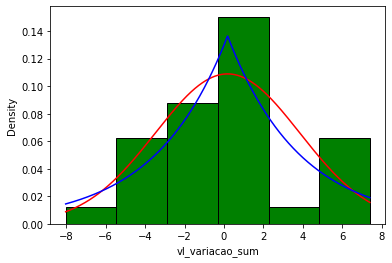

In [18]:
#aux['vl_variacao_sum'].hist(density = False)
sns.histplot(aux['vl_variacao_sum'], stat = "density", alpha = 1, color = "green")
mu = aux['vl_variacao_sum'].mean()
std = aux['vl_variacao_sum'].std()
x_axis = np.arange(aux['vl_variacao_sum'].min(), aux['vl_variacao_sum'].max(), 0.01)
plt.plot(x_axis, norm.pdf(x_axis, mu, std), color = "red")
plt.plot(x_axis, laplace.pdf(x_axis, loc = mu, scale = std), color = "blue")
print("Mu = {0}; Std = {1}".format(mu, std))

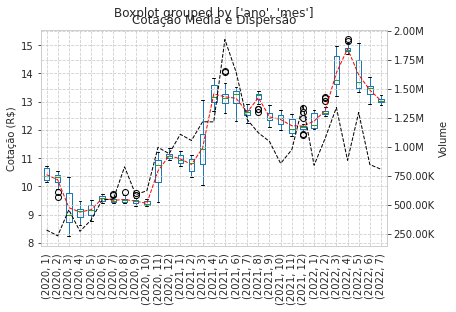

In [47]:
from matplotlib.ticker import FuncFormatter

def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

ax1 = pregao_plot.boxplot(column = 'vl_medio', by = ['ano', 'mes']);
aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': 'mean', 'vl_volume': 'mean'})
aux.index = np.arange(1, len(aux) + 1)
aux.plot.line(y = 'vl_medio', legend = False, ax = ax1, style = "--", color = 'red', linewidth = 1)
ax2 = ax1.twinx()
aux.plot.line(y = 'vl_volume', legend = False, ax = ax2, style = "--", color = 'black', linewidth = 1)
for label in ax1.get_xticklabels():
    label.set_rotation(90)  
ax1.set_title("Cotação Média e Dispersão")
ax1.set_xlabel("")
ax1.set_ylabel("Cotação (R$)")
ax2.set_ylabel("Volume")
ax2.yaxis.set_major_formatter(human_format)

In [54]:
pregao_plot.iloc[0][{'dt_pregao_dt', 'vl_abertura', 'vl_medio', 'vl_fechamento', 'vl_volume'}]

vl_medio               9.91
vl_abertura             9.9
dt_pregao_dt     2022-07-20
vl_fechamento          9.95
vl_volume        76160290.0
Name: 0, dtype: object

In [60]:
aux['dt_pregao_dt']

'2022-07-21'

In [72]:
scores = [1, 2]

In [76]:
np.mean(scores)

1.5